In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

from zerosearch_autosarimax import zerosearch_autosarimax as ZAZS

In [ ]:
df = pd.read_csv(r'macau2019.csv',sep=';').fillna(0) #weather data source: INMET
df.head()

,Data,Hora UTC,PRECIP,PRESS,PRESS MAX,PRESS MIN,RAD,TBS,TPO,TMAX,TMIN,TOMAX,TOMIN,UMIMAX,UMIMIN,UMI,ANG,VRAJ,VM
0,28/02/2019,1800 UTC,0.0,1008.2,1008.8,1008.2,1624.5,32.5,22.3,35.7,32.2,22.8,16.3,57.0,32.0,55.0,56,10.4,4.9
1,28/02/2019,1900 UTC,0.8,1008.1,1008.2,1008.0,1553.4,31.9,22.2,33.2,31.9,22.5,21.9,57.0,53.0,57.0,52,8.7,6.1
2,28/02/2019,2000 UTC,0.0,1008.5,1008.6,1008.1,619.5,30.9,22.3,31.9,30.9,22.4,21.6,60.0,56.0,60.0,59,9.5,5.7
3,28/02/2019,2100 UTC,0.0,1009.3,1009.3,1008.5,77.5,30.8,19.0,30.9,30.1,22.8,19.0,65.0,49.0,50.0,107,9.2,4.6
4,28/02/2019,2200 UTC,0.0,1010.0,1010.1,1009.3,0.0,30.0,17.2,30.8,30.0,18.8,16.7,50.0,44.0,46.0,99,7.7,4.3


ADF Test on non-seasonal differenced series (d=0): p-value = 0.0000
Non-seasonal series is stationary at d=0. Stopping.

--- Finding Order of Seasonal Differencing (D) for S=24 ---
ADF Test on seasonal differenced series (D=0): p-value = 0.0000
Seasonal series is stationary at D=0. Stopping.


--- Finding Autoregressive Order (p) and Seasonal Autoregressive Order (P) ---
Length of current_stationary_series: 476
Calculated max_lags_for_plots: 53
Confidence band critical value (centered at zero): +/- 0.3000


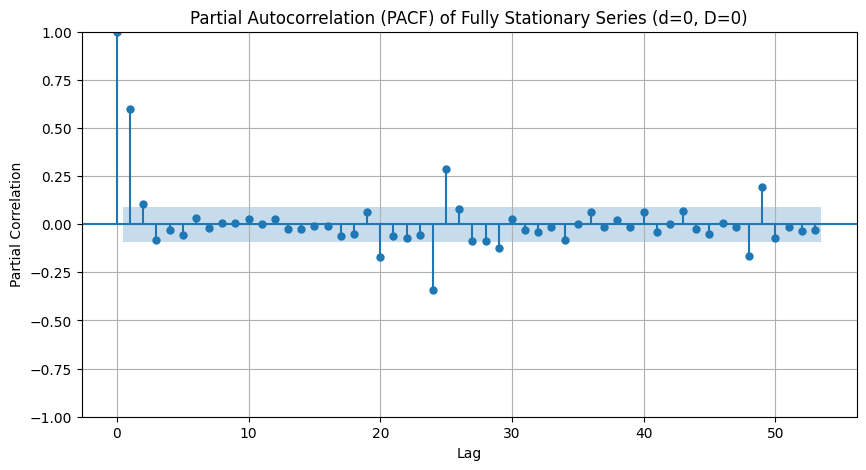

PACF values (first 5): [ 1.          0.59643743  0.1069169  -0.08339437 -0.02781838]
Last significant non-seasonal lag in PACF: 1. Setting p = 1.
Last significant seasonal lag in PACF (multiples of S=24): 2. Setting P = 2.

--- Finding Moving Average Order (q) and Seasonal Moving Average Order (Q) ---


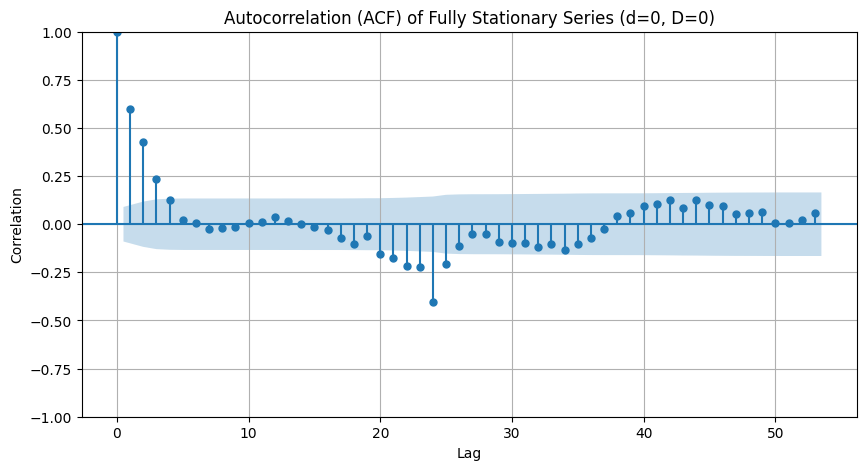

ACF values (first 5): [1.         0.59643743 0.42462014 0.2368372  0.12519492]
Last significant non-seasonal lag in ACF: 2. Setting q = 2.

Last significant seasonal lag in ACF (multiples of S=24): 2. Setting Q = 2.



In [4]:
train_start = 5000
train_end = 5500
pdq, PDQm = ZAZS(df['VM'].iloc[train_start:train_end],seasonal_period=24,verbose=2,thresholds=[0.3, 6, 0.3, 0, 6, 0])

In [5]:
pdq, PDQm

((1, 0, 2), (2, 0, 2, 24))

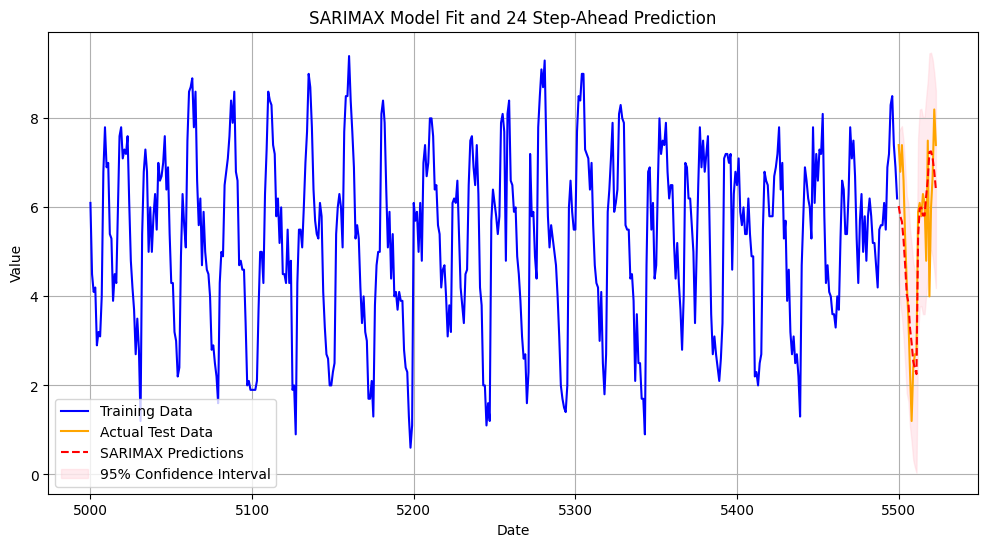

In [6]:
train_data = df['VM'].iloc[train_start:train_end].copy()
test_data = df['VM'].iloc[train_end:train_end+24].copy()
model = SARIMAX(train_data,
                order=pdq,
                seasonal_order=PDQm,
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit(disp=False)

forecast_start_index = len(train_data)
forecast_end_index = len(train_data)+23
predictions = model_fit.get_prediction(start=forecast_start_index, end=forecast_end_index, dynamic=False)
predicted_mean = predictions.predicted_mean
confidence_intervals = predictions.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Actual Test Data', color='orange')
plt.plot(predicted_mean.index, predicted_mean, label='SARIMAX Predictions', color='red', linestyle='--')
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('SARIMAX Model Fit and 24 Step-Ahead Prediction')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
